# Case Study: Credit Risk Prediction

This notebook builds a predictive classification model to identify credit card default payments based on customer attributes.

## Overview
### Objective:
Our goal is to:
- Preprocess the credit risk data using encoding methods.
- Train and tune predictive models using cross-validations with multiple algorithms
- Compare the models based on metrics including accuracy, precision, recall, F1-score
- Identify the best performing model based on these criteria and evaluate it on the test set
- Compute the optimal classification threshold for the selected model

### Dataset:
The dataset includes one target variable and 23 predictor variables:

- Target Variable (Y): Indicates whether the customer defaulted on a credit card payment (Yes = 1, No = 0).

- Predictor Variables (X1 to X23):
  - X1: Credit amount (NT dollar).
  - X2: Gender (1 = male; 2 = female).
  - X3: Education level (1 = graduate school; 2 = university; 3 = high school; 4 = others).
  - X4: Marital status (1 = married; 2 = single; 3 = others).
  - X5: Age (years).
  - X6 - X11: Historical monthly repayment statuses (-1 = paid duly, 1-9 = months delayed).
  - X12 - X17: Monthly bill statement amounts (NT dollar).
  - X18 - X23: Amount paid each month (NT dollar).

### Tasks
1. Load and preprocess the training and test datasets, clearly applying appropriate encodings
2. Train and tune models using cross-validation for each algorithm, illustrating hyperparameter tuning clearly with plots.
3. Select and justify the best-performing model.
4. Evaluate the selected best model on the test set using suitable classification metrics.
5. Compute the optimal probability threshold for classifying defaults, improving the performance evaluation.


## Setup and Data Loading


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
)
from sklearn.svm import SVC

from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV,
    TunedThresholdClassifierCV
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# For reproducibility: random states of all estimators
# are automatically set to this value
np.random.seed(42)

In [3]:
# Console markdown variables
UNDERLINE = "\033[04m"
BOLD = "\033[01m"
GREEN = "\033[92m"
BLUE = "\033[34m"
RESET = "\033[0m"

In [4]:
# Load train and test data
train_df = pd.read_csv("creditdefault_train.csv")
test_df = pd.read_csv("creditdefault_test.csv")

print(train_df.head())

   Y      X1  X2  X3  X4  X5  X6  X7  X8  X9  ...     X14     X15     X16  \
0  1   20000   2   2   1  24   2   2  -1  -1  ...     689       0       0   
1  0   50000   2   2   1  37   0   0   0   0  ...   49291   28314   28959   
2  0   50000   1   2   1  57  -1   0  -1   0  ...   35835   20940   19146   
3  0   50000   1   1   2  37   0   0   0   0  ...   57608   19394   19619   
4  0  500000   1   1   2  29   0   0   0   0  ...  445007  542653  483003   

      X17    X18    X19    X20    X21    X22    X23  
0       0      0    689      0      0      0      0  
1   29547   2000   2019   1200   1100   1069   1000  
2   19131   2000  36681  10000   9000    689    679  
3   20024   2500   1815    657   1000   1000    800  
4  473944  55000  40000  38000  20239  13750  13770  

[5 rows x 24 columns]


In [5]:
# Separate features from labels
X_train = train_df.drop("Y", axis=1)
y_train = train_df["Y"]

X_test = test_df.drop("Y", axis=1)
y_test = test_df["Y"]

In [6]:
X_train.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000
mean,167450.245333,1.604867,1.850000,1.556200,35.367933,-0.020467,-0.130933,-0.163000,-0.214467,-0.256933,...,47117.562067,43077.445667,40272.922667,38708.685867,5615.960000,5.822059e+03,4942.959000,4997.328867,4798.478400,5226.421267
std,130109.925023,0.488896,0.786686,0.522743,9.154118,1.125048,1.198451,1.202606,1.180578,1.148654,...,69182.434940,64016.907786,60503.339354,59212.425410,15551.708028,2.155675e+04,13629.034736,16499.349511,15463.948485,18099.851948
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-34041.000000,-170000.000000,-46627.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2733.500000,2392.750000,1800.000000,1200.000000,1000.000000,8.330000e+02,390.000000,290.000000,204.000000,80.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20165.000000,19090.500000,18178.000000,17177.000000,2113.000000,2.014000e+03,1809.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,60263.250000,54599.500000,50134.750000,49122.750000,5023.250000,5.000000e+03,4571.500000,4048.500000,4019.500000,4000.000000
max,800000.000000,2.000000,6.000000,3.000000,75.000000,8.000000,8.000000,8.000000,8.000000,7.000000,...,855086.000000,706864.000000,587067.000000,568638.000000,493358.000000,1.227082e+06,380478.000000,528897.000000,426529.000000,528666.000000


In [7]:
# Check for missing values
print(X_train.loc[X_train.isnull().any(axis=1)])
print(X_test.loc[X_test.isnull().any(axis=1)])

Empty DataFrame
Columns: [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23]
Index: []

[0 rows x 23 columns]


## Exploratory Data Analysis
We begin our analysis with an exploration of the data structure and target variable to understand the distribution of classes and the behaviour of features.

### Class Imbalance
One of the key challenges observed in the dataset is the **imbalance seen in the label `Y`**, which represents whether a credit card holder defaulted on their payment (1 = default, 0 = no default).

The plot below shows that:
- Approximately **77.8%** of the training samples belong to class **0** (no default).
- Only **22.2%** of samples represent the positive class **1** (default).

This imbalance poses a risk of developing biased models that favour predicting the majority class. For instance, a model that always predicts “no default” would achieve nearly 78% accuracy but would completely fail to identify defaulters, which are the most important cases for a credit risk model.

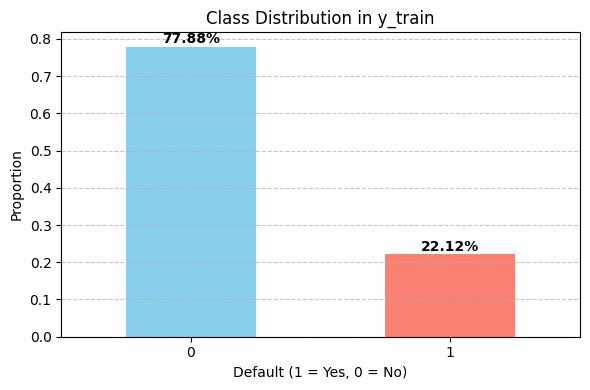

In [20]:
import matplotlib.pyplot as plt

# Get class distribution (normalized)
class_dist = y_train.value_counts(normalize=True)

# Plot
plt.figure(figsize=(6,4))
class_dist.plot(kind='bar', color=['skyblue', 'salmon'])

# Labeling
plt.title('Class Distribution in y_train')
plt.xlabel('Default (1 = Yes, 0 = No)')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show percentage on top of bars
for i, v in enumerate(class_dist):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


### Distribution of Numeric Features
To understand the spread and range of the input features, we plotted histograms of all the variables.

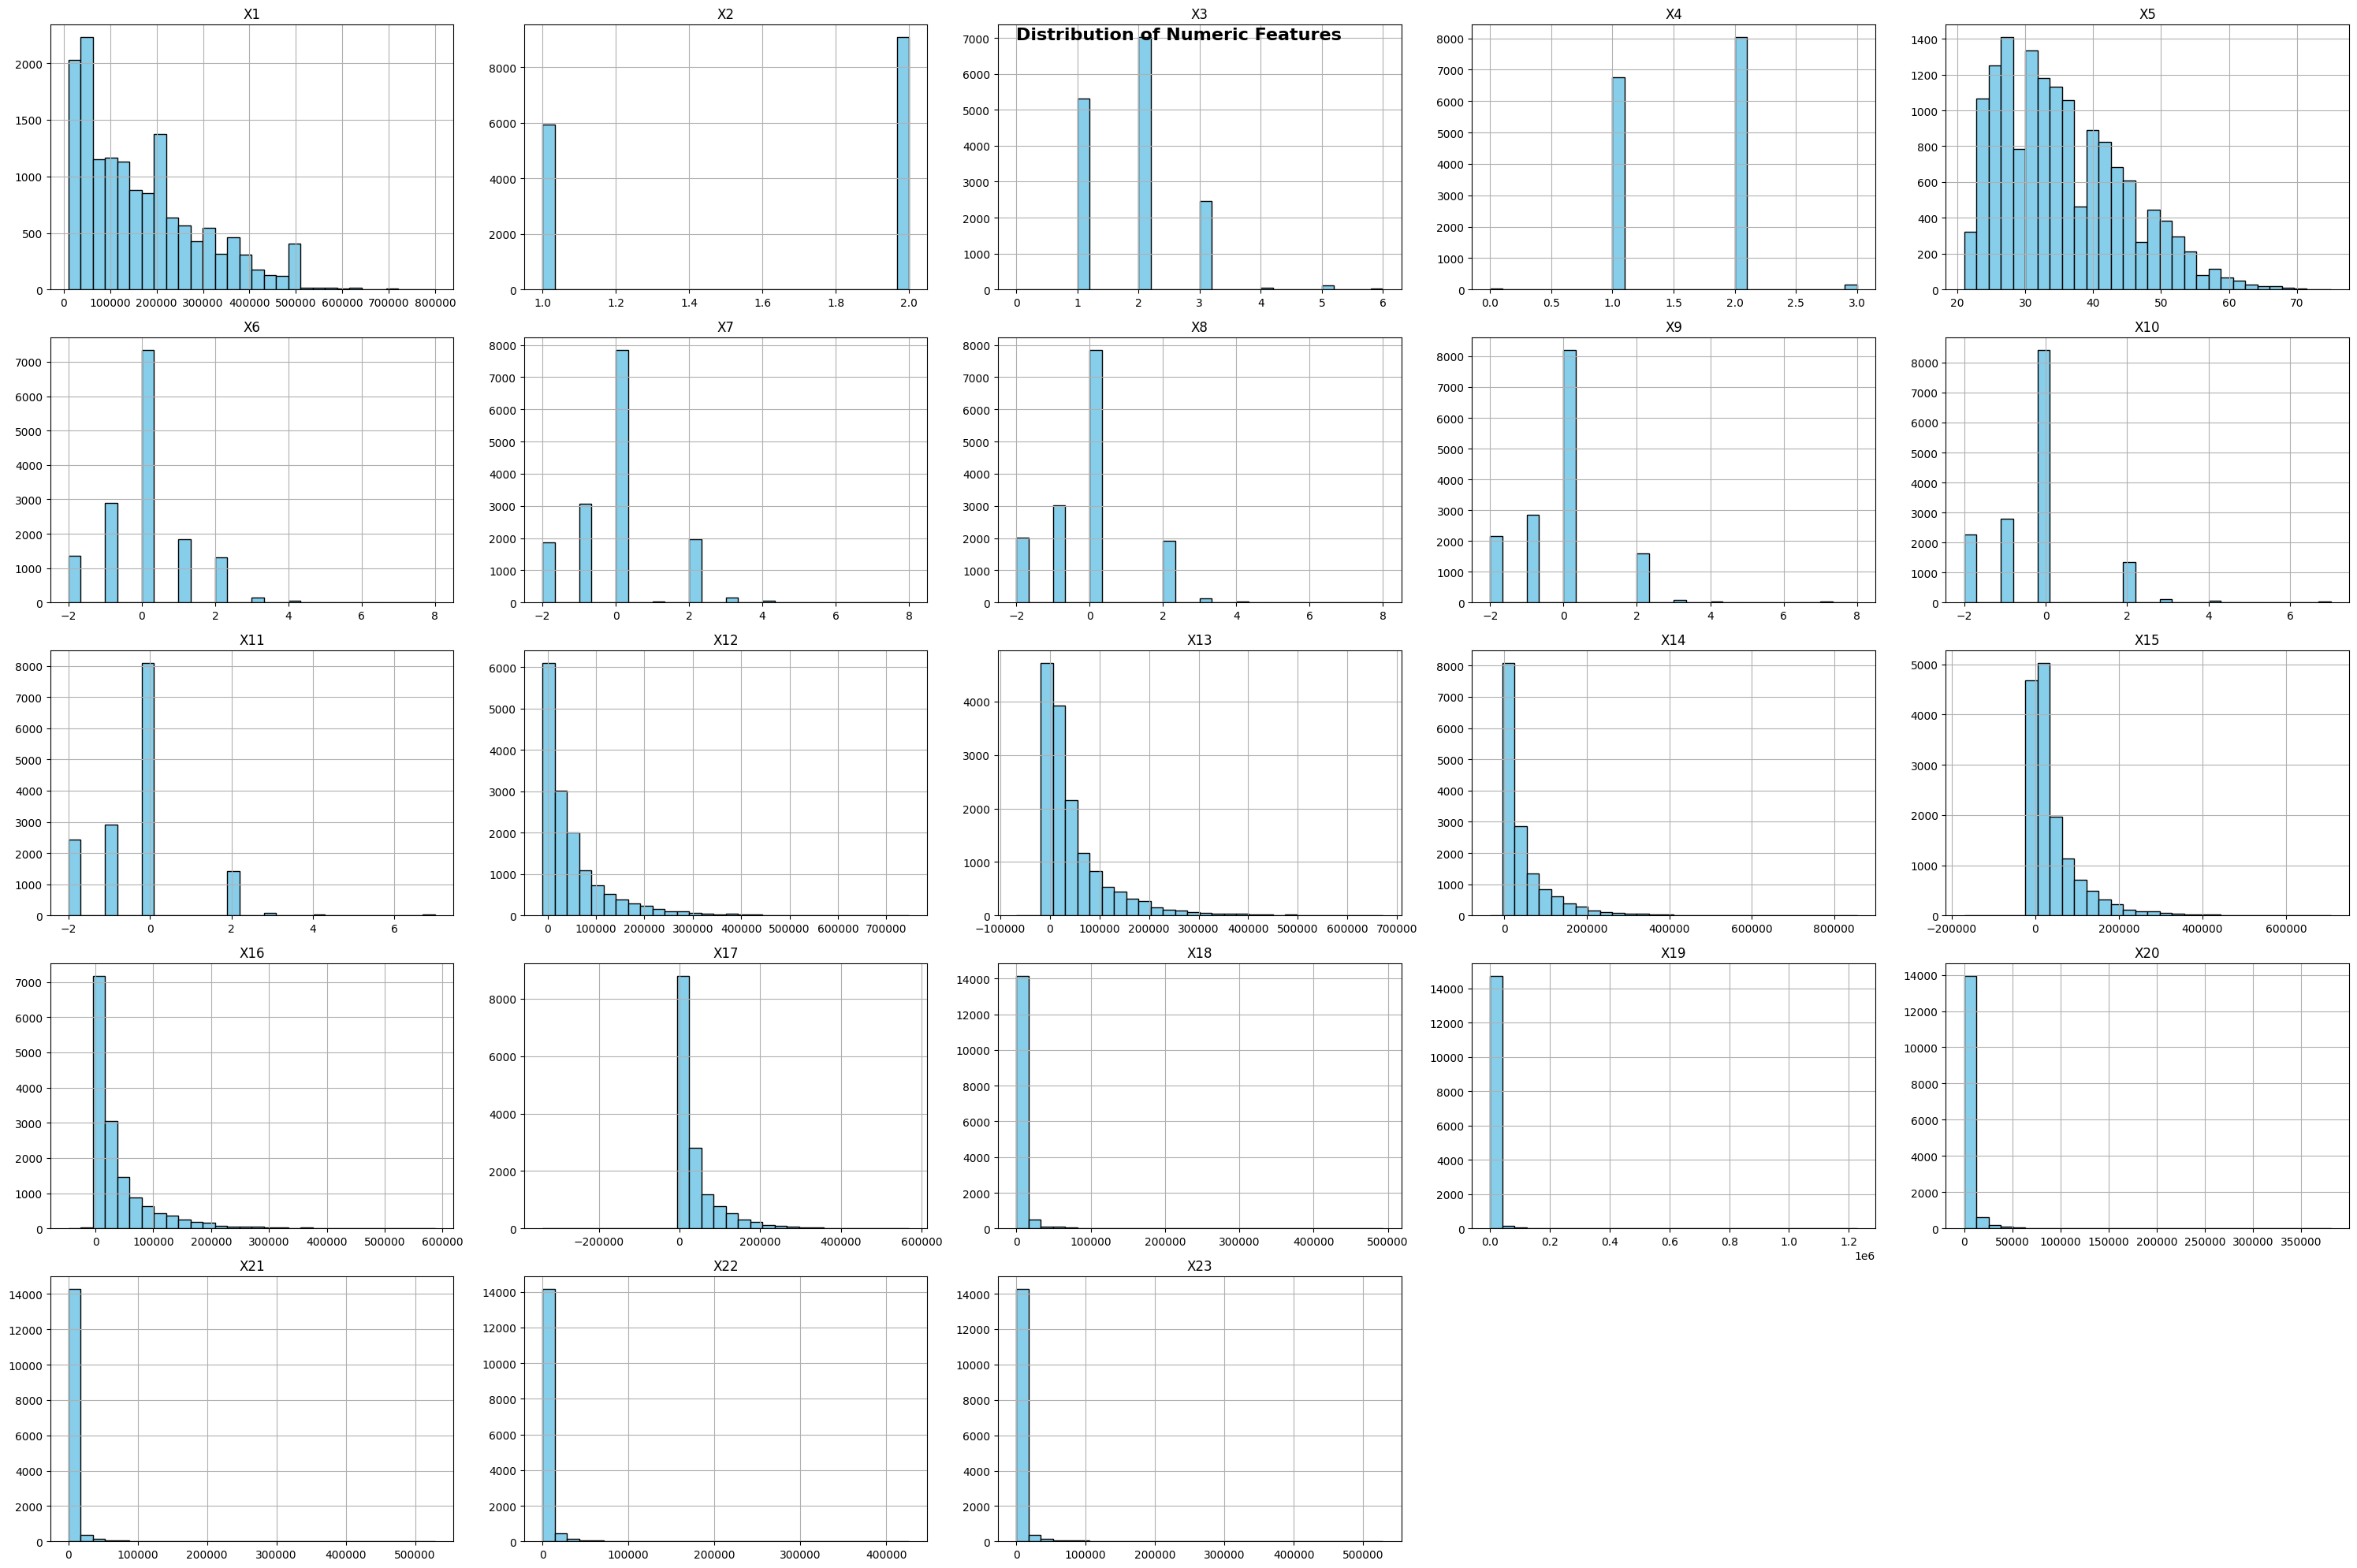

In [21]:
#plot all numeric features
numeric_features = train_df.drop(columns=["Y"]).select_dtypes(include=[np.number]).columns

train_df[numeric_features].hist(bins=30, figsize=(30, 20), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.suptitle('Distribution of Numeric Features', fontsize=16, fontweight='bold')
plt.show()

In [43]:
train_df["X17"].sort_values(ascending=True)[:20]

## Building a Preprocessing Pipeline

The nominal features `gender (X2)` and `marital status (X4)` should be one-hot encoded using sklearn's `OneHotEncoder` class, as they have no natural order.

Ordinal features such as `education level (X3)` and `historical monthly repayment statuses (X6-X11)` are already ordinally encoded in this dataset, and so will be passed through with no transformation.

Numerical features will be standardised using sklearn's `StandardScaler` class, to prevent features with larger ranges from disproportionately affecting predictions.

In [22]:
def preprocess_data(X: pd.DataFrame) -> np.ndarray:
    nom_cols = ["X2", "X4"] # X2 = gender, X4 = marital status
    ord_cols = ["X3", "X6", "X7", "X8", "X9", "X10", "X11"]

    nominal_features = list(X[nom_cols].copy())
    ordinal_features = list(X[ord_cols].copy())
    numerical_features = list(X.drop(ord_cols + nom_cols, axis=1))

    full_pipeline = ColumnTransformer([
        ("nom", OneHotEncoder(), nominal_features),     # One-hot encode nominal features
        ("ord", "passthrough", ordinal_features),       # Ordinal features already encoded
        ("num", StandardScaler(), numerical_features),  # Standardise numerical features
    ])

    return full_pipeline.fit_transform(X)

In [23]:
prepared_X_train = preprocess_data(X_train)

prepared_X_train.shape

(15000, 27)

## Training Models

We trained and fine-tuned several classifiers using Grid Search with 5-fold cross-validation to predict credit card defaults. The main metric we used was the F1-score, as it equally considers both precision (correct predictions of defaults) and recall (not missing actual defaults). This approach is important because the dataset may have more non-default cases than defaults.

### Model Tuning

**model_trainer**

A custom function that automates the hyperparameter tuning of an estimator, returning the best estimator and cross validation results.

In [ ]:
def model_trainer(
    model, 
    X: np.ndarray,
    y: pd.Series,
    param_grid: dict[str, list],
    validation_folds: int = 5,
    verbose: bool = True,
    random: bool = False
) -> tuple:
    """
    Perform a grid/random search fitted to the given features and labels
    on an estimator, returning a tuple containing the best found estimator
    and the search results.
    """
    print(f"{BLUE}Search Parameters:{RESET}")
    for k, v in param_grid.items():
        print(f"{k}: {v}")
    print(f"\n{BLUE}Validation Folds:{RESET}\n{validation_folds}")
    print(f"\n{UNDERLINE}{BLUE}Performing grid search...{RESET}")

    if random: # Perform a random search
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            cv=validation_folds,
            n_jobs=-1,
            scoring=["accuracy", "precision", "recall", "f1"],
            refit="f1",
            return_train_score=True
        ).fit(X, y)
    else: # Perform a grid search
        search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=validation_folds,
            n_jobs=-1,
            scoring=["accuracy", "precision", "recall", "f1"],
            refit="f1",
            return_train_score=True,
        ).fit(X, y)

    cv_results = search.cv_results_

    # Print the results of the hyperparameter search
    if verbose:
        for i, (mean_f1, mean_pre, mean_rec, mean_acc, params) in enumerate(zip(
            cv_results["mean_test_f1"], cv_results["mean_test_precision"],
            cv_results["mean_test_recall"], cv_results["mean_test_accuracy"],
            cv_results["params"])):
            print(f"\n{BOLD}{BLUE}{i+1}:{RESET} {params}")
            print(f"    Mean F1 Score: {GREEN}{round(mean_f1, 3)}{RESET}")
            print(f"    Mean Precision: {GREEN}{round(mean_pre, 3)}{RESET}")
            print(f"    Mean Recall: {GREEN}{round(mean_rec, 3)}{RESET}")
            print(f"    Mean Accuracy: {GREEN}{round(mean_acc, 3)}{RESET}")

    # Print the best estimator's result
    print(f"\n{UNDERLINE}{BLUE}BEST RESULT:{RESET}\n")
    print(f"{BOLD}{BLUE}{search.best_index_+1}:{RESET} {search.best_params_}")
    print(f"    Mean F1 Score: {GREEN}{round(search.best_score_, 3)}{RESET}\n")

    return search.best_estimator_, cv_results

**model_threshold_tuner**

A function to be used as a final tuning step to find the optimal model to use on the test set. It automatically tunes the decision threshold of an estimator to optimise the F1 score.

In [ ]:
def model_threshold_tuner(
    model,
    X: np.ndarray,
    y: pd.Series,
    validation_folds: int = 5,
) -> tuple:
    """
    Perform an automatic search on a given estimator for the
    best decision threshold to optimise F1.
    """
    tuned_threshold = TunedThresholdClassifierCV(
        estimator=model,
        cv=validation_folds, 
        n_jobs=-1,
        scoring="f1",
        store_cv_results=True,
    ).fit(X, y)
    
    cv_results = tuned_threshold.cv_results_

    print(f"Best threshold: {tuned_threshold.best_threshold_:.3f}")
    print(f"Best F1 score: {tuned_threshold.best_score_:.3f}")

    return tuned_threshold.estimator_, cv_results

### Plotting

**plot_accuracy_vs_hyperparameter**

Plots training and test accuracies against one hyperparameter changed in isolation, to measure how it can affect model performance individually.

In [ ]:
def plot_accuracy_vs_hyperparameter(
    cv_results: dict[str, np.ndarray], 
    param_name: str
) -> None:
    """
    Display the change in training and test accuracies for an estimator
    as one selected hyperparameter is varied.
    """
    test_acc = "mean_test_accuracy"
    train_acc = "mean_train_accuracy"

    # Convert cv_results into a DataFrame for easier manipulation.
    df = pd.DataFrame(cv_results)
    
    # Build the column name (e.g., 'max_features' becomes 'param_max_features').
    col_name = f"param_{param_name}"
    
    # Extract the relevant columns.
    data = df[[col_name, test_acc, train_acc]].copy()
    
    # Check if the hyperparameter values are numeric.
    if pd.api.types.is_numeric_dtype(data[col_name]):
        # Group by the numeric hyperparameter and sort by the index.
        grouped_test = data.groupby(col_name)[test_acc].mean().sort_index()
        grouped_train = data.groupby(col_name)[train_acc].mean().sort_index()
        x_values = grouped_test.index
    else:
        # If values are non-numeric, convert them to strings and group without sorting.
        grouped_test = data.groupby(col_name)[test_acc].mean()
        grouped_train = data.groupby(col_name)[train_acc].mean()
        x_values = grouped_test.index.astype(str)
    
    # Extract y-values for both metrics.
    y_test_values = grouped_test.values
    y_train_values = grouped_train.values

    # Create the plot.
    plt.figure(figsize=(8, 5))
    plt.plot(x_values, y_test_values, label='Test Accuracy', linestyle='-', color='blue')
    plt.plot(x_values, y_train_values, label='Train Accuracy', linestyle='-', color='orange')
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.title(f'Test and Train Accuracy vs. {param_name}')
    plt.legend()
    plt.show()

**plot_roc_curve**

Displays the ROC curve for a model on a test set to inform the selection of a decision threshold.

In [32]:
def plot_roc_curve(model, X_test,y_test,model_name="Model", preprocessing_func=None) -> None:
    """
    Plot the ROC curve for a given model and test data.
    """
    if preprocessing_func:
        X_test = preprocessing_func(X_test)

    # Get predicted probabilities for the positive class
    y_scores = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

### K-Nearest Neighbour Classifier

The ***k-Nearest Neighbour (k-NN)*** algorithm predicts a class by looking at how the closest training points (neighbours) are labelled. It does not train a model in advance but instead makes predictions based on stored data.

We tuned the following hyperparameters:

- `n_neighbors`: This controls how many nearby data points the model looks at when making a prediction. A small number might be too sensitive to noise. A large number might make the model too general and miss details.

- `p`: This sets how distance is calculated. It's part of the Minkowski distance formula:

    - `p` = 1: Measures distance using straight lines (like city blocks). This is called Manhattan distance.

    - `p` = 2: Measures distance "as the crow flies". This is Euclidean distance, the most common choice.

    - Higher values give more weight to larger differences in features.

- `weights`: This setting decides how much each neighbour contributes to the prediction:

    - `'uniform'`: Every neighbour counts the same.

    - `'distance'`: Neighbours that are closer to the data point have more influence.

#### Initial Grid Search
We started with a wide search to explore different combinations of settings. We tested:

- Six different values for the number of neighbours (`n_neighbors`),

- Five different distance powers (p),

- Two types of weighting (uniform and distance).

Here’s the code we used:

In [ ]:
k_neighbours = KNeighborsClassifier()

k_neighbours_param_grid = {
    "n_neighbors": [1,2,3,4,5,6],           # Number of nearest neighbours to consider
    "p": [1,2,3,4,5],                       # Power to use for Minkowski distance
    "weights": ["uniform", "distance"],     # Weight function to use
}

k_neighbours, results = model_trainer(
    k_neighbours, 
    prepared_X_train, 
    y_train, 
    k_neighbours_param_grid,
)

k_neighbours

Best result from this search:
``` python
{'n_neighbors': 6, 'p': 5, 'weights': 'distance'}
F1 Score: 0.432
```

This setup gave us the best F1-score in the first round. It used the highest number of neighbours we tested (`n_neighbors = 6`). This told us the model performed better when it considered more data points. Also, using `p = 5` (a higher-than-usual distance metric) gave better results, and the `distance` weighting helped nearby points influence the decision more.

#### Refined Grid Search
Because the best result came from the highest `n_neighbors` value tested, we wondered if the model would improve even more with higher values. So, we ran a second grid search, testing:

- Explore whether performance kept improving beyond `n_neighbors = 6`,

- Check whether `p = 5` was optimal or if nearby values like 4 or 6 were better,

- Only using  `'distance'` weighting (since it worked better than `'uniform'` earlier).

In [ ]:
k_neighbours_param_grid = {
    "n_neighbors": [6,7,8,9,10],
    "p": [4,5,6],
    "weights": ["distance"],
}

k_neighbours, results = model_trainer(
    k_neighbours, 
    prepared_X_train, 
    y_train, 
    k_neighbours_param_grid,
)

k_neighbours


From this search, the best parameter values found were:

``` python
{'n_neighbors': 9, 'p': 6, 'weights': 'distance'}
F1 Score: 0.444
Precision: 0.611
Recall: 0.350
Accuracy: 0.806
```

This result was better than the first round. The model became more stable and accurate. Increasing the number of neighbours to 9 made it less sensitive to small changes in the data. Using `p = 6` helped the model calculate distances in a smarter way. Giving more importance to nearby points (`'distance'` weighting) helped the model make better decisions near the class boundaries.

In [ ]:
k_neighbours_param_grid = {
    "n_neighbors": range(1, 21),
    "p": [6],
    "weights": ["distance"]
}

k_neighbours, results = model_trainer(
    k_neighbours, 
    prepared_X_train, 
    y_train, 
    k_neighbours_param_grid
)

plot_accuracy_vs_hyperparameter(results, param_name="n_neighbors")

Search Parameters:
n_neighbors: range(1, 21)
p: [6]
weights: ['distance']

Validation Folds:
5

Performing grid search...


#### Summary

By increasing the number of neighbours, the model became more reliable and less affected by random noise. Giving more weight to close neighbours improved prediction quality, especially when the data points were near a decision boundary. Adjusting the `p` value changed how the model compared points and helped it find better patterns in the data.

### Decision Tree Classifier
Decision Trees work by splitting the data with a series of simple conditions. Each split tries to separate the data into smaller groups where the target labels are as similar as possible.

We focused on tuning the following three important settings, also known as hyperparameters:

- `max_depth`: This controls how deep the tree can grow. A deeper tree can learn more patterns, but it might overfit (learn noise instead of useful information). Limiting the depth helps prevent this.

- `min_samples_split`: This sets the smallest number of samples that must be present in a node before it can be split. If we set this too low, the tree might create unnecessary branches. A higher value helps the tree stay simpler.

- `min_samples_leaf`: This controls the minimum number of samples required to be in a final leaf node. Leaf nodes are where predictions are made. Using a higher value makes the tree more stable and general.

#### Initial Grid Search

We started by trying a wide range of values for these settings. The goal was to explore different tree shapes and find a good balance between learning enough and keeping the model simple. Here's the code we used:

In [27]:
decision_tree = DecisionTreeClassifier(class_weight="balanced")

decision_tree_param_grid = {
    "max_depth": [3, 4, 5, 6],              # Pre-pruning, prevents tree from growing further
    "min_samples_split": [2, 3, 4, 5],      # Min. samples at a node needed to split further
    "min_samples_leaf": [1, 3, 5, 7],       # Min. samples needed at a leaf node
}

decision_tree, results = model_trainer(
    decision_tree,
    prepared_X_train,
    y_train,
    decision_tree_param_grid
)

decision_tree

Search Parameters:
max_depth: [3, 4, 5, 6]
min_samples_split: [2, 3, 4, 5]
min_samples_leaf: [1, 3, 5, 7]

Validation Folds:
5

Performing grid search...

1: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
    Mean F1 Score: 0.514
    Mean Precision: 0.47
    Mean Recall: 0.567
    Mean Accuracy: 0.763

2: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3}
    Mean F1 Score: 0.514
    Mean Precision: 0.47
    Mean Recall: 0.567
    Mean Accuracy: 0.763

3: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4}
    Mean F1 Score: 0.514
    Mean Precision: 0.47
    Mean Recall: 0.567
    Mean Accuracy: 0.763

4: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
    Mean F1 Score: 0.514
    Mean Precision: 0.47
    Mean Recall: 0.567
    Mean Accuracy: 0.763

5: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
    Mean F1 Score: 0.514
    Mean Precision: 0.47
    Mean Recall: 0.567
    Mean Accuracy: 0.763

6: {'max_depth'

DecisionTreeClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=7)

From this search, the best parameter values found were:
```python
{'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 7}
F1 Score: 0.484
Precision: 0.659
Recall: 0.383
Accuracy: 0.819
```
This result tells us that a tree with a depth of 5, splitting when there are at least 3 samples, and with leaves having at least 7 samples, gives us the best balance of precision and recall. 

#### Refined Grid Search
After finding a strong setup in the initial search, we decided to focus on fine-tuning one specific setting: min_samples_leaf.

We kept the other two settings fixed:
- `max_depth = 5`

- `min_samples_split = 2`

Then we tested several values for`min_samples_leaf` to see if we could improve performance even more:

In [28]:
decision_tree_param_grid = {
    "max_depth": [4],
    "min_samples_split": [2],
    "min_samples_leaf": [7, 8, 9, 10, 11, 12, 13, 14],
}

decision_tree, results = model_trainer(
    decision_tree,
    prepared_X_train,
    y_train,
    decision_tree_param_grid
)

decision_tree

Search Parameters:
max_depth: [4]
min_samples_split: [2]
min_samples_leaf: [7, 8, 9, 10, 11, 12, 13, 14]

Validation Folds:
5

Performing grid search...

1: {'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 2}
    Mean F1 Score: 0.518
    Mean Precision: 0.502
    Mean Recall: 0.535
    Mean Accuracy: 0.78

2: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 2}
    Mean F1 Score: 0.518
    Mean Precision: 0.502
    Mean Recall: 0.535
    Mean Accuracy: 0.78

3: {'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 2}
    Mean F1 Score: 0.518
    Mean Precision: 0.502
    Mean Recall: 0.535
    Mean Accuracy: 0.779

4: {'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 2}
    Mean F1 Score: 0.518
    Mean Precision: 0.502
    Mean Recall: 0.535
    Mean Accuracy: 0.78

5: {'max_depth': 4, 'min_samples_leaf': 11, 'min_samples_split': 2}
    Mean F1 Score: 0.519
    Mean Precision: 0.503
    Mean Recall: 0.537
    Mean Accuracy: 0.78

6: {'max_dept

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=11)

The best result from this refined search was still:
```python
{'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 7}
F1 Score: 0.483
Precision: 0.658
Recall: 0.383
Accuracy: 0.819
```
This outcome was very close to the earlier best result. It confirmed that setting min_samples_leaf = 7 was the best choice. Increasing this number any further caused a small drop in performance. 

In [29]:
best_decision_tree, results = model_threshold_tuner(decision_tree, prepared_X_train, y_train)

Best threshold: 0.605
Best F1 score: 0.520


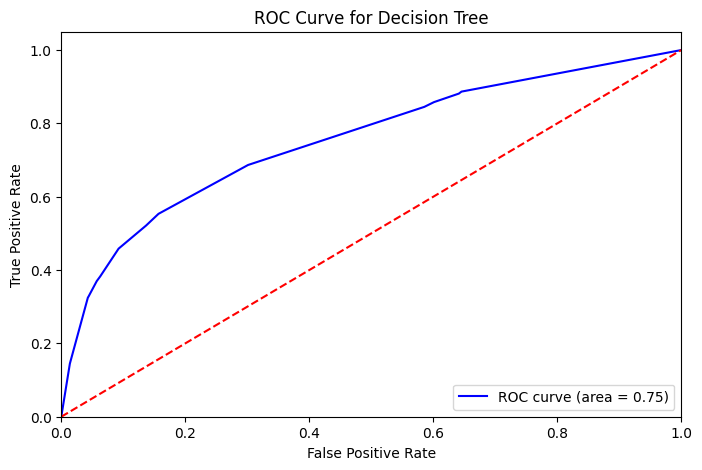

In [34]:
plot_roc_curve(
    model=best_decision_tree,
    X_test=X_test,
    y_test=y_test,
    model_name="Decision Tree",
    preprocessing_func=preprocess_data
)

Search Parameters:
max_depth: range(1, 101)

Validation Folds:
5

Performing grid search...

1: {'max_depth': 1}
    Mean F1 Score: 0.509
    Mean Precision: 0.504
    Mean Recall: 0.515
    Mean Accuracy: 0.78

2: {'max_depth': 2}
    Mean F1 Score: 0.509
    Mean Precision: 0.504
    Mean Recall: 0.515
    Mean Accuracy: 0.78

3: {'max_depth': 3}
    Mean F1 Score: 0.515
    Mean Precision: 0.471
    Mean Recall: 0.568
    Mean Accuracy: 0.763

4: {'max_depth': 4}
    Mean F1 Score: 0.519
    Mean Precision: 0.503
    Mean Recall: 0.537
    Mean Accuracy: 0.78

5: {'max_depth': 5}
    Mean F1 Score: 0.511
    Mean Precision: 0.447
    Mean Recall: 0.606
    Mean Accuracy: 0.743

6: {'max_depth': 6}
    Mean F1 Score: 0.509
    Mean Precision: 0.439
    Mean Recall: 0.613
    Mean Accuracy: 0.735

7: {'max_depth': 7}
    Mean F1 Score: 0.506
    Mean Precision: 0.445
    Mean Recall: 0.591
    Mean Accuracy: 0.744

8: {'max_depth': 8}
    Mean F1 Score: 0.492
    Mean Precision: 0.407

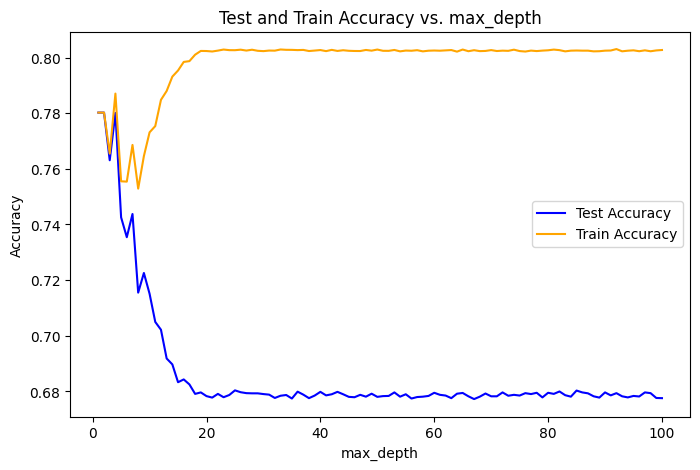

In [35]:
decision_tree, results = model_trainer(
    decision_tree,
    prepared_X_train,
    y_train,
    {"max_depth": range(1, 101)}
)

plot_accuracy_vs_hyperparameter(results, param_name="max_depth")

#### Summary

In the initial grid search, we explored many combinations of tree depth, minimum samples required to split a node, and minimum samples required at each leaf. The best combination we found had a maximum depth of 5, a split size of 3, and 7 samples per leaf. This setup produced strong and balanced performance across all key metrics. Following this, we carried out a refined grid search where we kept the tree depth and split size fixed, and only varied the minimum number of samples at each leaf. This helped us confirm that 7 was still the optimal value. When we increased the leaf size beyond 7, the F1 score dropped slightly, so we kept the original value as our final choice.

### Random Forest Classifier
Random Forest is an ensemble learning method that builds multiple Decision Trees on different subsets of the data and features. It then combines the predictions from all trees to make a final decision. This approach reduces overfitting and improves accuracy compared to a single Decision Tree.

We tuned the following hyperparameters:

- ` n_estimators`: The number of trees in the forest. A higher number usually improves performance but increases training time.

- `max_features`: The number of features to consider when looking for the best split. This controls how diverse the trees are.

- `max_depth`: The maximum depth of each tree. Trees with no limit (None) can become very deep and may overfit.

- `min_samples_leaf`: The minimum number of samples required to be at a leaf node. This keeps trees from being too specific and helps with generalisation.

#### Initial Grid Search

In our first grid search, we used a large number of trees (`n_estimators=500`) and explored many values for max_features. We also tested both unlimited depth and a limited depth of 5. The leaf size was fixed at 7, which was found to work well in earlier Decision Tree tuning.

In [ ]:
random_forest = RandomForestClassifier(class_weight="balanced")

random_forest_param_grid = {
    "n_estimators": [500],      # Use a larger number of trees
    "max_features": [           # Amount of features to use when splitting nodes
        None, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, "sqrt", "log2"
    ],
    "max_depth": [None, 4],     # Allow trees to overfit, or use optimal decision tree depth
    "min_samples_leaf": [11],   # Optimal min samples per leaf for decision tree
}

random_forest, results = model_trainer(
    random_forest,
    prepared_X_train,
    y_train,
    random_forest_param_grid
)

random_forest

NameError: name 'model_trainer' is not defined

Best result from this grid search:
```python
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 7, 'n_estimators': 500}
F1 Score: 0.479
Precision: 0.675
Recall: 0.371
Accuracy: 0.821
```

This result shows that the best model used all available features for splitting (`max_features=None`), no restriction on tree depth, and 500 trees. This allowed each tree to grow fully and capture complex patterns. The use of a minimum of 7 samples per leaf helped control overfitting. Together, these choices gave the best balance between precision and recall.

#### Refined Grid Search 

To further fine-tune the model, we can run a second grid search. This time, we’ll fix the best parameters from the initial search and vary the `min_samples_leaf` and `max_depth` values more closely.

In [2]:
random_forest_param_grid = {
    "n_estimators": [500],
    "max_features": ["log2"],
    "max_depth": [None],
    "min_samples_leaf": [7, 8, 9, 10, 11, 12, 13, 14, 15],
}

random_forest, results = model_trainer(
    random_forest,
    prepared_X_train,
    y_train,
    random_forest_param_grid
)


NameError: name 'model_trainer' is not defined

The best configuration from this refined search was:
``` python
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 7, 'n_estimators': 500}
F1 Score: 0.481
Precision: 0.678
Recall: 0.373
Accuracy: 0.822
```
This confirms the original setting of 7 samples per leaf as optimal. Changing the depth to values like 10, 15, or 20 did not result in better performance than leaving it unrestricted (`None`). Similarly, adjusting the minimum number of samples per leaf up or down from 7 slightly reduced the F1 score.

Although a few nearby configurations (like `min_samples_leaf=6` or `max_depth=10`) showed competitive performance, none of them consistently improved all key metrics. Therefore, the original setup remains the best balance between model complexity and generalisation.


In [ ]:
random_forest, results = model_trainer(
    random_forest,
    prepared_X_train,
    y_train,
    {"max_features": range(27, 0, -1)}
)

plot_accuracy_vs_hyperparameter(results, param_name="max_features")

#### Summary

In summary, the initial grid search explored a wide range of values for `max_features` and tree depth, with the best result achieved using `max_depth=None`, `max_features=None`, and `min_samples_leaf=7`. The refined grid search focused more narrowly on adjusting the number of samples per leaf and limiting tree depth, but the original configuration continued to deliver the highest F1 score. This confirmed that our earlier tuning was already close to optimal. Overall, the final Random Forest model showed strong and consistent performance, offering a solid balance between precision and recall. By allowing the trees to grow without depth restriction while maintaining regularisation at the leaf level, we were able to capture important patterns in the data without overfitting.

## Bagging Classifier
Bagging is a method that builds several versions of the same model using different random subsets of the training data. Each model learns slightly different patterns, and their combined predictions help make the final result more stable and accurate.

We focused on tuning the following three hyperparameters:

- `n_estimators`: This controls how many individual models (also called base estimators) are used in the ensemble. Using more models often improves performance but also increases training time.

- `max_samples`: This sets the fraction of the original training data that each base model sees. Smaller values add more randomness, which can help avoid overfitting.

- `max_features`: This sets the fraction of the total number of features that each model can use. Just like max_samples, limiting features can make the overall model more diverse and less likely to overfit.

#### Initial Grid Search
We started by testing a wide range of values for each of the three hyperparameters. The goal was to explore different combinations of randomness and ensemble size to find the best setup. Here's the code we used:

In [ ]:
# Instantiate the BaggingClassifier with a fixed random state for reproducibility
bagging_classifier = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight="balanced"))

# Define the hyperparameter grid
bagging_param_grid = {
    "n_estimators": [500],                          # Number of trees
    "max_features": np.linspace(0.1, 1.0, num=10),  #
    "max_samples": np.linspace(0.1, 1.0, num=10)
}

# Perform grid search with cross-validation using the helper function
bagging_classifier, results = model_trainer(
    bagging_classifier,
    prepared_X_train,
    y_train,
    bagging_param_grid
)

# Display the best Bagging classifier
bagging_classifier


NameError: name 'BaggingClassifier' is not defined

From this search, the best parameter values were:
``` python
{'n_estimators': 150, 'max_samples': 0.7, 'max_features': 1.0}
F1 Score: 0.481
Precision: 0.663
Recall: 0.378
Accuracy: 0.820
```
This setup used the largest number of estimators, a full set of features, and half the training samples for each base model. It provided the best F1 score and a solid balance between precision and recall.

#### Refined Grid Search

After finding a strong combination in the initial grid search, we narrowed our focus to just one setting: max_samples. This was the only value we hadn’t yet explored in finer detail.

We kept the best values from earlier fixed:

- `n_estimators = 100`

- `max_features = 1.0`

Then, we tested a smaller range of values for max_samples to see if we could push the F1 score even higher:

In [ ]:
bagging_classifier = BaggingClassifier()

bagging_param_grid = {
    "n_estimators": [140,150,160],
    "max_samples": [0.6, 0.7, 0.8],    # Nearby values around the original 0.7
    "max_features": [0.9, 1.0],        # Try using all or nearly all features
}

bagging_classifier, results = model_trainer(
    bagging_classifier,
    prepared_X_train,
    y_train,
    bagging_param_grid
)

bagging_classifier

Search Parameters:
n_estimators: [140, 150, 160]
max_samples: [0.6, 0.7, 0.8]
max_features: [0.9, 1.0]

Validation Folds:
5

Performing grid search...

1: {'max_features': 0.9, 'max_samples': 0.6, 'n_estimators': 140}
    Mean F1 Score: 0.471
    Mean Precision: 0.664
    Mean Recall: 0.365
    Mean Accuracy: 0.819

2: {'max_features': 0.9, 'max_samples': 0.6, 'n_estimators': 150}
    Mean F1 Score: 0.472
    Mean Precision: 0.663
    Mean Recall: 0.367
    Mean Accuracy: 0.819

3: {'max_features': 0.9, 'max_samples': 0.6, 'n_estimators': 160}
    Mean F1 Score: 0.471
    Mean Precision: 0.656
    Mean Recall: 0.368
    Mean Accuracy: 0.817

4: {'max_features': 0.9, 'max_samples': 0.7, 'n_estimators': 140}
    Mean F1 Score: 0.474
    Mean Precision: 0.663
    Mean Recall: 0.37
    Mean Accuracy: 0.819

5: {'max_features': 0.9, 'max_samples': 0.7, 'n_estimators': 150}
    Mean F1 Score: 0.471
    Mean Precision: 0.658
    Mean Recall: 0.367
    Mean Accuracy: 0.818

6: {'max_features':

BaggingClassifier(max_features=0.9, max_samples=0.8, n_estimators=140)

## AdaBoost Classifier
AdaBoost builds sequential classifiers, each correcting the errors of the previous one, creating a stronger overall prediction.

In [ ]:
# Instantiate the AdaBoostClassifier with a fixed random state for reproducibility
adaboost_classifier = AdaBoostClassifier(algorithm="SAMME")

# Define the hyperparameter grid for AdaBoost
adaboost_param_grid = {
    "n_estimators": [50, 100, 200],     # Number of weak learners to combine
    "learning_rate": [0.5, 1.0, 1.5]    # Weight applied to each classifier at each boosting iteration
}

# Perform grid search with cross-validation using the helper function
adaboost_classifier = model_trainer(
    adaboost_classifier,
    prepared_X_train,
    y_train,
    adaboost_param_grid
)

# Display the best AdaBoost classifier
adaboost_classifier


Search Parameters:
n_estimators: [50, 100, 200]
learning_rate: [0.5, 1.0, 1.5]

Validation Folds:
5

Performing grid search...

1: {'learning_rate': 0.5, 'n_estimators': 50}
    Mean F1 Score: 0.457
    Mean Precision: 0.699
    Mean Recall: 0.34
    Mean Accuracy: 0.821

2: {'learning_rate': 0.5, 'n_estimators': 100}
    Mean F1 Score: 0.457
    Mean Precision: 0.698
    Mean Recall: 0.34
    Mean Accuracy: 0.821

3: {'learning_rate': 0.5, 'n_estimators': 200}
    Mean F1 Score: 0.457
    Mean Precision: 0.695
    Mean Recall: 0.34
    Mean Accuracy: 0.821

4: {'learning_rate': 1.0, 'n_estimators': 50}
    Mean F1 Score: 0.449
    Mean Precision: 0.7
    Mean Recall: 0.331
    Mean Accuracy: 0.821

5: {'learning_rate': 1.0, 'n_estimators': 100}
    Mean F1 Score: 0.45
    Mean Precision: 0.696
    Mean Recall: 0.332
    Mean Accuracy: 0.82

6: {'learning_rate': 1.0, 'n_estimators': 200}
    Mean F1 Score: 0.449
    Mean Precision: 0.693
    Mean Recall: 0.333
    Mean Accuracy: 0.82



AdaBoostClassifier(algorithm='SAMME', learning_rate=0.5)

## Support Vector Machine (SVM)
SVM draws the best boundary between classes. It can handle complex data by using kernel functions. Here, we used the Radial Basis Function (RBF) kernel, which is good for non-linear patterns.

We used grid search with 5-fold cross-validation to test different values for the regularisation parameter C and the kernel parameter gamma.

In [ ]:
svm_classifier = SVC(class_weight="balanced")

# Define the hyperparameter grid for the SVM classifier
svm_param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale','auto']
}

# Perform grid search with cross-validation using the helper function
svm_classifier = model_trainer(
    svm_classifier,
    prepared_X_train,
    y_train,
    svm_param_grid
)

# Display the best SVM classifier
svm_classifier


Search Parameters:
kernel: ['linear', 'rbf', 'poly', 'sigmoid']
C: [0.1, 1, 10, 100]
gamma: ['scale', 'auto']

Validation Folds:
5

Performing grid search...

1: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    Mean F1 Score: 0.37
    Mean Precision: 0.712
    Mean Recall: 0.251
    Mean Accuracy: 0.811

2: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    Mean F1 Score: 0.418
    Mean Precision: 0.686
    Mean Recall: 0.301
    Mean Accuracy: 0.814

3: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
    Mean F1 Score: 0.276
    Mean Precision: 0.716
    Mean Recall: 0.172
    Mean Accuracy: 0.801

4: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
    Mean F1 Score: 0.293
    Mean Precision: 0.324
    Mean Recall: 0.268
    Mean Accuracy: 0.714

5: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
    Mean F1 Score: 0.37
    Mean Precision: 0.712
    Mean Recall: 0.251
    Mean Accuracy: 0.811

6: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
    Mean F1 Score: 0.421
    Mean Precis

SVC(C=10)

In [ ]:
svm_classifier = SVC()

# Define the hyperparameter grid for the SVM classifier
svm_param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale','auto']
}

# Perform grid search with cross-validation using the helper function
svm_classifier = model_trainer(
    svm_classifier,
    prepared_X_train,
    y_train,
    svm_param_grid
)

# Display the best SVM classifier
svm_classifier


Search Parameters:
kernel: ['rbf']
C: [0.1, 1, 10, 100]
gamma: ['scale', 'auto']

Validation Folds:
5

Performing grid search...

1: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    Mean F1 Score: 0.418
    Mean Precision: 0.686
    Mean Recall: 0.301
    Mean Accuracy: 0.814

2: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
    Mean F1 Score: 0.421
    Mean Precision: 0.687
    Mean Recall: 0.304
    Mean Accuracy: 0.815

3: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
    Mean F1 Score: 0.443
    Mean Precision: 0.697
    Mean Recall: 0.325
    Mean Accuracy: 0.819

4: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
    Mean F1 Score: 0.445
    Mean Precision: 0.699
    Mean Recall: 0.327
    Mean Accuracy: 0.82

5: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
    Mean F1 Score: 0.459
    Mean Precision: 0.683
    Mean Recall: 0.346
    Mean Accuracy: 0.82

6: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
    Mean F1 Score: 0.458
    Mean Precision: 0.678
    Mean Recall: 0.346
    Mean Accu

SVC(C=10)

The best combination was:

- **C** = 10  
- **gamma** = `'scale'`  
- **kernel** = `'rbf'`  

With this setup, we achieved:

- **F1-score**: 0.459  
- **Precision**: 0.683  
- **Recall**: 0.346  
- **Accuracy**: 0.820  

These results indicate that the model performs reasonably well at identifying defaults. Precision is stronger than recall, meaning that when the model predicts a default, it is likely to be correct — but it still misses many actual defaults.

In [11]:
svm_param_grid = {
    'kernel': ['rbf'],
    'C': [5,6,7,8, 9, 10, 11, 12],
    'gamma': ['scale']
}

# Perform grid search with cross-validation
svm_classifier = model_trainer(
    svm_classifier,
    prepared_X_train,
    y_train,
    svm_param_grid
)

# Display the best SVM classifier
svm_classifier

Search Parameters:
kernel: ['rbf']
C: [5, 6, 7, 8, 9, 10, 11, 12]
gamma: ['scale']

Validation Folds:
5

Performing grid search...

1: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
    Mean F1 Score: 0.46
    Mean Precision: 0.692
    Mean Recall: 0.345
    Mean Accuracy: 0.821

2: {'C': 6, 'gamma': 'scale', 'kernel': 'rbf'}
    Mean F1 Score: 0.459
    Mean Precision: 0.69
    Mean Recall: 0.345
    Mean Accuracy: 0.821

3: {'C': 7, 'gamma': 'scale', 'kernel': 'rbf'}
    Mean F1 Score: 0.461
    Mean Precision: 0.688
    Mean Recall: 0.347
    Mean Accuracy: 0.821

4: {'C': 8, 'gamma': 'scale', 'kernel': 'rbf'}
    Mean F1 Score: 0.46
    Mean Precision: 0.686
    Mean Recall: 0.347
    Mean Accuracy: 0.82

5: {'C': 9, 'gamma': 'scale', 'kernel': 'rbf'}
    Mean F1 Score: 0.459
    Mean Precision: 0.683
    Mean Recall: 0.346
    Mean Accuracy: 0.82

6: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
    Mean F1 Score: 0.459
    Mean Precision: 0.683
    Mean Recall: 0.346
    Mean Accurac

SVC(C=7)